In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = SparkConf().setAppName('myApp') \
.setMaster('local')
sc = SparkContext(conf=conf)
spark = SparkSession(sc) 

In [2]:
from pyspark.sql.functions import *
import pandas as pd
import math

In [3]:
df_application = spark.read.format('csv').options(header=True,inferSchema=True).load('application_record.csv')
df_application.show(30, truncate=50)
df_application.printSchema()

+-------+-----------+------------+---------------+------------+----------------+--------------------+-----------------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE|          NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|
+-------+-----------+------------+---------------+------------+----------------+--------------------+-----------------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|5008804|          M|           Y|              Y|           0|        427500.0|             Working|             Higher education|      Civil marriage| Rented apartment

In [4]:
# Check for null etc.
df_application.select([count((when(isnan(c) | isnull(c), 1))).alias(c) for c in df_application.columns]).show()
# No null in data so all data is valid

+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
| ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|
+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|  0|          0|           0|              0|           0|               0|               0|                  0|                 0|                0|         0|            0|         0|              0|         0|         0|     

In [5]:
# First Check the data in code_gender to check if there is any misdata
# Select and show distinct values for each column separately
# List of columns to check for distinct values
columns = [
    'code_gender',
    'flag_own_car',
    'flag_own_realty',
    'flag_mobil',
    'flag_work_phone',
    'flag_email',
    'flag_phone'
]

# Loop through each column and display distinct values
for column in columns:
    df_application.select(column).distinct().show()


+-----------+
|code_gender|
+-----------+
|          F|
|          M|
+-----------+

+------------+
|flag_own_car|
+------------+
|           Y|
|           N|
+------------+

+---------------+
|flag_own_realty|
+---------------+
|              Y|
|              N|
+---------------+

+----------+
|flag_mobil|
+----------+
|         1|
+----------+

+---------------+
|flag_work_phone|
+---------------+
|              1|
|              0|
+---------------+

+----------+
|flag_email|
+----------+
|         1|
|         0|
+----------+

+----------+
|flag_phone|
+----------+
|         1|
|         0|
+----------+



In [6]:
# After checking the flag_mobil is not important because the data is only 1 and no other variation. so in the cleaned data not getting the flag mobil
df_app_cleaned = df_application.select(['id','code_gender','flag_own_car','flag_own_realty','cnt_children','amt_income_total',
                                        'name_income_type','name_education_type','name_family_status','name_housing_type','days_birth',
                                        'days_employed','flag_work_phone','flag_phone','flag_email','occupation_type','cnt_fam_members'])

# AND the value is always 0 an 1 as the boolean so we want to make our data uniform so changing the Y as 1 and N as 0, F as 1 and M as 0
df_app_cleaned = df_app_cleaned.withColumn('code_gender', when(df_app_cleaned.code_gender == 'F',1).otherwise(0))
df_app_cleaned = df_app_cleaned.withColumn('flag_own_car', when(df_app_cleaned.flag_own_car == 'Y',1).otherwise(0))
df_app_cleaned = df_app_cleaned.withColumn('flag_own_realty', when(df_app_cleaned.flag_own_car == 'Y',1).otherwise(0))

# More data cleaning cnt_fam_members should be integer because there shouldn't be fam members that is half or less than 1
df_app_cleaned = df_app_cleaned.withColumn('cnt_fam_members', col('cnt_fam_members').cast('Integer'))

df_app_cleaned.show()
df_app_cleaned.select('id').distinct().count()

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+
|     id|code_gender|flag_own_car|flag_own_realty|cnt_children|amt_income_total|    name_income_type| name_education_type|  name_family_status|name_housing_type|days_birth|days_employed|flag_work_phone|flag_phone|flag_email|occupation_type|cnt_fam_members|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+
|5008804|          0|           1|              0|           0|        427500.0|             Working|    Higher education|      Civil marriage| Rented apartment|    -12005|        -4542|              1|         0|         0|     

438510

In [7]:
# Changing the days birth into age Integer so that it will be classification into its correspondence age
df_app_cleaned = df_app_cleaned.withColumn('age', floor(col('days_birth')/365.25) * -1)

# Check value because age should not be negative or even > 100
df_app_cleaned.select('age').where('age < 0 or age > 100').show()

# Changing the days birth into age Integer so that it will be classification into its correspondence age
df_app_cleaned = df_app_cleaned.withColumn('employed', floor(col('days_employed')/365.25) * -1)

# Check value because age should not be negative or even > 100 as well as the occupation
df_app_cleaned.select(['name_income_type','occupation_type','employed']).where('employed < 0 or employed > 100').distinct().show()

+---+
|age|
+---+
+---+

+----------------+---------------+--------+
|name_income_type|occupation_type|employed|
+----------------+---------------+--------+
|       Pensioner|           NULL|    -999|
+----------------+---------------+--------+



In [8]:
# because the data is said pensioner than it is possible that the employed is negative but for calculation sake it is better to make it into 0
df_app_cleaned = df_app_cleaned.withColumn('employed', when(df_app_cleaned.employed < 0,0).otherwise(df_app_cleaned.employed))

df_app_cleaned.show()

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+---+--------+
|     id|code_gender|flag_own_car|flag_own_realty|cnt_children|amt_income_total|    name_income_type| name_education_type|  name_family_status|name_housing_type|days_birth|days_employed|flag_work_phone|flag_phone|flag_email|occupation_type|cnt_fam_members|age|employed|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+---+--------+
|5008804|          0|           1|              0|           0|        427500.0|             Working|    Higher education|      Civil marriage| Rented apartment|    -12005|        -4542|    

In [9]:
# there is occupation type that is null so we need to fill it up
df_app_cleaned.select('occupation_type').where(isnull(col('occupation_type'))).count()
# There are no possibility to

134203

In [10]:
# check for occupation type that is null
df_app_cleaned.select(['amt_income_total','name_income_type','occupation_type','employed']).where(isnull(df_app_cleaned.occupation_type)).show()
# there is possibility to use the amt_income_total & name_income_type to classified the occupation_type typically will have the same job
# so need to find the exact number to it

+----------------+----------------+---------------+--------+
|amt_income_total|name_income_type|occupation_type|employed|
+----------------+----------------+---------------+--------+
|        427500.0|         Working|           NULL|      13|
|        427500.0|         Working|           NULL|      13|
|        283500.0|       Pensioner|           NULL|       0|
|        283500.0|       Pensioner|           NULL|       0|
|        283500.0|       Pensioner|           NULL|       0|
|        112500.0|         Working|           NULL|       5|
|        112500.0|         Working|           NULL|       5|
|        112500.0|         Working|           NULL|       5|
|        315000.0|       Pensioner|           NULL|       0|
|        225000.0|         Working|           NULL|       8|
|        225000.0|         Working|           NULL|       8|
|        225000.0|         Working|           NULL|       8|
|        225000.0|         Working|           NULL|       8|
|        157500.0|      

In [11]:
# use amt_income total to get the kind of occupation type check first
# the possibility is that the amt_income_total,name_income_type, and employed can fill the occupation_type that is null
df_app_cleaned.select(['amt_income_total','name_income_type','occupation_type','employed']).where((df_app_cleaned.amt_income_total == 225000.0) & (df_app_cleaned.name_income_type == 'Working')).show()
# This data further proven the point that it will be able to be filled up

+----------------+----------------+---------------+--------+
|amt_income_total|name_income_type|occupation_type|employed|
+----------------+----------------+---------------+--------+
|        225000.0|         Working|           NULL|       8|
|        225000.0|         Working|           NULL|       8|
|        225000.0|         Working|           NULL|       8|
|        225000.0|         Working|           NULL|       8|
|        225000.0|         Working|       Managers|       3|
|        225000.0|         Working|       Managers|       3|
|        225000.0|         Working|       Managers|       3|
|        225000.0|         Working|       Managers|       3|
|        225000.0|         Working|       Managers|       3|
|        225000.0|         Working|       Managers|       3|
|        225000.0|         Working|       Managers|       3|
|        225000.0|         Working|       Managers|       3|
|        225000.0|         Working|       Managers|       3|
|        225000.0|      

In [12]:
# so use the possibility of it and fill the occupation_type that got from the amt_income_total and name_income_type
from pyspark.sql import Window, functions as F

# Define a window specification
window_spec = Window.partitionBy('amt_income_total', 'name_income_type')

# Fill missing values of occupation_type with the most frequent value within each group
filled_occupation_type = F.first('occupation_type', ignorenulls=True).over(window_spec)

# Fill missing values using coalesce
df_app_cleaned = df_app_cleaned.withColumn('filled_occupation_type', filled_occupation_type)
df_app_cleaned = df_app_cleaned.withColumn('occupation_type', F.coalesce('occupation_type', 'filled_occupation_type')).drop('filled_occupation_type')

df_app_cleaned.show()

+-------+-----------+------------+---------------+------------+----------------+----------------+--------------------+--------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+---+--------+
|     id|code_gender|flag_own_car|flag_own_realty|cnt_children|amt_income_total|name_income_type| name_education_type|  name_family_status|name_housing_type|days_birth|days_employed|flag_work_phone|flag_phone|flag_email|occupation_type|cnt_fam_members|age|employed|
+-------+-----------+------------+---------------+------------+----------------+----------------+--------------------+--------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+---+--------+
|6093713|          1|           0|              0|           0|         26100.0|       Pensioner|Secondary / secon...|             Married|House / apartment|    -21003|       365243|              0|    

In [13]:
# check for occupation type that is null  and that the amt_income_total and name_income_type same, but still null
df_app_cleaned.select(['amt_income_total','name_income_type','occupation_type','employed']).where(isnull(df_app_cleaned.occupation_type) & (df_app_cleaned.employed != 0)).show()
# There are no exact data to fill the null in that missing value, so the possibility is the same name_income_type with the nearest amt_income_total
# Create a window specification to partition by 'name_income_type' and order by the absolute difference in 'amt_income_total'
window_spec = Window.partitionBy('name_income_type').orderBy(F.abs(F.col('amt_income_total') - F.col('amt_income_total_with_null')))

# Create a temporary column to store the amt_income_total of rows with null occupation_type
df_temp = df_app_cleaned.withColumn('amt_income_total_with_null', F.when(F.col('occupation_type').isNull(), F.col('amt_income_total')))

# Fill missing occupation_type using the nearest amt_income_total
filled_occupation_type = F.first('occupation_type', ignorenulls=True).over(window_spec)
df_temp = df_temp.withColumn('filled_occupation_type', filled_occupation_type)

# Use coalesce to fill the null values
df_app_cleaned = df_temp.withColumn('occupation_type', F.coalesce(F.col('occupation_type'), F.col('filled_occupation_type'))).drop('filled_occupation_type', 'amt_income_total_with_null')

df_app_cleaned.show()

+----------------+--------------------+---------------+--------+
|amt_income_total|    name_income_type|occupation_type|employed|
+----------------+--------------------+---------------+--------+
|         32400.0|             Working|           NULL|       5|
|         32400.0|             Working|           NULL|       5|
|         32400.0|             Working|           NULL|       5|
|         38250.0|       State servant|           NULL|       3|
|         38250.0|       State servant|           NULL|       3|
|         38250.0|       State servant|           NULL|       3|
|         38250.0|       State servant|           NULL|       3|
|         38250.0|       State servant|           NULL|       3|
|         38250.0|       State servant|           NULL|       3|
|         38250.0|       State servant|           NULL|       3|
|         38700.0|             Working|           NULL|      26|
|         41211.0|Commercial associate|           NULL|       6|
|         41211.0|Commerc

In [14]:
# check for occupation type that is null
df_app_cleaned.select(['amt_income_total','name_income_type','occupation_type','employed']).where(isnull(df_app_cleaned.occupation_type)).show()
# Data already cleaned!!

+----------------+----------------+---------------+--------+
|amt_income_total|name_income_type|occupation_type|employed|
+----------------+----------------+---------------+--------+
+----------------+----------------+---------------+--------+



In [15]:
df_credit = spark.read.format('csv').options(header=True,inferSchema=True).load('credit_record.csv')
df_credit.show(30, truncate=50)
df_credit.printSchema()
print('Status \n\
      0 => 1-29 days past due \n\
      1 => 30-59 days past due \n\
      2 => 60-89 days past due \n\
      3 => 90-119 days past due \n\
      4 => 120-149 days past due \n\
      5 => overdue/ bad debts > 150 days \n\
      C => paid successfully \n\
      X => No loan \n\
')
# The schema is already correct with id and months_balance as Integer.

+-------+--------------+------+
|     ID|MONTHS_BALANCE|STATUS|
+-------+--------------+------+
|5001711|             0|     X|
|5001711|            -1|     0|
|5001711|            -2|     0|
|5001711|            -3|     0|
|5001712|             0|     C|
|5001712|            -1|     C|
|5001712|            -2|     C|
|5001712|            -3|     C|
|5001712|            -4|     C|
|5001712|            -5|     C|
|5001712|            -6|     C|
|5001712|            -7|     C|
|5001712|            -8|     C|
|5001712|            -9|     0|
|5001712|           -10|     0|
|5001712|           -11|     0|
|5001712|           -12|     0|
|5001712|           -13|     0|
|5001712|           -14|     0|
|5001712|           -15|     0|
|5001712|           -16|     0|
|5001712|           -17|     0|
|5001712|           -18|     0|
|5001713|             0|     X|
|5001713|            -1|     X|
|5001713|            -2|     X|
|5001713|            -3|     X|
|5001713|            -4|     X|
|5001713

In [16]:
# Check for null etc.
# Display the count of null values for each column
df_credit.select([count(when(isnan(c) | isnull(c), 1)).alias(c) for c in df_credit.columns]).show()

# List of status values to count
status_values = [0, 1, 2, 3, 4, 5, 'C', 'X']

# Loop through each status value and print the count
for status in status_values:
    count_value = df_credit.select('status').where(col('status') == status).count()
    print(f"{status}: {count_value}")

+---+--------------+------+
| ID|MONTHS_BALANCE|STATUS|
+---+--------------+------+
|  0|             0|     0|
+---+--------------+------+

0: 383120
1: 11090
2: 868
3: 320
4: 223
5: 1693
C: 442031
X: 209230


In [17]:
# convert each status to points
# X is 0 because there is no loan 
# 0 - 5 is negative value [-5,-10,-20,-50,-100]
# C is positive value of + 20
# Define the mapping from status to points
status_to_points = {
    'X': 0,
    0: -5,
    1: -10,
    2: -20,
    3: -50,
    4: -100,
    5: -1000,
    'C': 50
}

# Convert the mapping dictionary to a column expression
points_expr = when(col('status') == 'X', status_to_points['X']) \
    .when(col('status') == 'C', status_to_points['C'])

for status in range(6):
    points_expr = points_expr.when(col('status') == status, status_to_points[status])

# Add the new column with points to the DataFrame
df_credit_processed = df_credit.withColumn('points', points_expr)

df_credit_processed.show()

df_credit_processed.select('id').distinct().count()

+-------+--------------+------+------+
|     ID|MONTHS_BALANCE|STATUS|points|
+-------+--------------+------+------+
|5001711|             0|     X|     0|
|5001711|            -1|     0|    -5|
|5001711|            -2|     0|    -5|
|5001711|            -3|     0|    -5|
|5001712|             0|     C|    50|
|5001712|            -1|     C|    50|
|5001712|            -2|     C|    50|
|5001712|            -3|     C|    50|
|5001712|            -4|     C|    50|
|5001712|            -5|     C|    50|
|5001712|            -6|     C|    50|
|5001712|            -7|     C|    50|
|5001712|            -8|     C|    50|
|5001712|            -9|     0|    -5|
|5001712|           -10|     0|    -5|
|5001712|           -11|     0|    -5|
|5001712|           -12|     0|    -5|
|5001712|           -13|     0|    -5|
|5001712|           -14|     0|    -5|
|5001712|           -15|     0|    -5|
+-------+--------------+------+------+
only showing top 20 rows



45985

In [18]:
# then do aggregate data on the same id customer
df_credit_processed = df_credit_processed.drop('status')
df_credit_processed = df_credit_processed.groupby('id')\
                        .agg(
                            count('months_balance').alias('month_count'),
                            sum('points').alias('sum_points')
                        )
df_credit_processed = df_credit_processed.withColumn('avg_points', col('sum_points') / col('month_count'))
df_credit_processed = df_credit_processed.drop('month_count','sum_points')
df_credit_processed.show()

+-------+-------------------+
|     id|         avg_points|
+-------+-------------------+
|5001812|               -5.0|
|5001849|  7.222222222222222|
|5001921|               18.0|
|5003338|               -5.0|
|5003386|               -5.0|
|5003485| -4.705882352941177|
|5003623| 43.888888888888886|
|5004426|  42.72727272727273|
|5004485|  2.142857142857143|
|5004511|               -5.4|
|5004620| -4.705882352941177|
|5004650| 23.026315789473685|
|5004774| 25.344827586206897|
|5005000|-0.7142857142857143|
|5005607|  39.44444444444444|
|5005681| 18.870967741935484|
|5009033|-1.1764705882352942|
|5009304|  7.857142857142857|
|5009355|-4.8076923076923075|
|5009429|               -5.0|
+-------+-------------------+
only showing top 20 rows



In [19]:
# count the positive and negative sum_points, 
# the point distributed where good is called when point is > 10 why is that it is because below 10 you still commited blunder when paying so there are consequences.
print(f"good : {df_credit_processed.select('avg_points').where(df_credit_processed.avg_points >= 10).count()}")
print(f"normal : {df_credit_processed.select('avg_points').where((df_credit_processed.avg_points < 10) & (df_credit_processed.avg_points > -3)).count()}")
print(f"bad : {df_credit_processed.select('avg_points').where(df_credit_processed.avg_points <= -3).count()}")

# labeling the data
df_credit_processed = df_credit_processed.withColumn('result',when(col('avg_points') >= 10,'good').when(col('avg_points') <= -3,'bad').otherwise('normal'))
df_credit_processed.show()

good : 20398
normal : 10935
bad : 14652
+-------+-------------------+------+
|     id|         avg_points|result|
+-------+-------------------+------+
|5001812|               -5.0|   bad|
|5001849|  7.222222222222222|normal|
|5001921|               18.0|  good|
|5003338|               -5.0|   bad|
|5003386|               -5.0|   bad|
|5003485| -4.705882352941177|   bad|
|5003623| 43.888888888888886|  good|
|5004426|  42.72727272727273|  good|
|5004485|  2.142857142857143|normal|
|5004511|               -5.4|   bad|
|5004620| -4.705882352941177|   bad|
|5004650| 23.026315789473685|  good|
|5004774| 25.344827586206897|  good|
|5005000|-0.7142857142857143|normal|
|5005607|  39.44444444444444|  good|
|5005681| 18.870967741935484|  good|
|5009033|-1.1764705882352942|normal|
|5009304|  7.857142857142857|normal|
|5009355|-4.8076923076923075|   bad|
|5009429|               -5.0|   bad|
+-------+-------------------+------+
only showing top 20 rows



In [20]:
# join the data of application to credit data
df_joined_processed = df_app_cleaned.join(df_credit_processed,on='id',how='inner')

# df_joined_processed.show()
df_joined_processed.select([count((when(isnan(c) | isnull(c), 1))).alias(c) for c in df_joined_processed.columns]).show()
df_joined_processed.select([count(c).alias(c) for c in df_joined_processed.columns]).show()
# no null data

+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+---+--------+----------+------+
| id|code_gender|flag_own_car|flag_own_realty|cnt_children|amt_income_total|name_income_type|name_education_type|name_family_status|name_housing_type|days_birth|days_employed|flag_work_phone|flag_phone|flag_email|occupation_type|cnt_fam_members|age|employed|avg_points|result|
+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+---+--------+----------+------+
|  0|          0|           0|              0|           0|               0|               0|                  0|                 0|                0|         0|        

******Starting EDA Process over the Result******

In [21]:
from pyspark.sql.functions import when, col, count, lit, log
from pyspark.sql import DataFrame

def calculate_iv(df: DataFrame, feature: str, target: str) -> float:
    # Create the contingency table for the feature and target
    contingency_table = df.groupBy(feature, target).count()

    # Calculate the total count of each target value
    total_count = df.count()
    result_total_count = df.groupBy(target).count().withColumnRenamed('count', 'result_total_count')
    
    # Calculate the total count of each feature value
    feature_total_count = df.groupBy(feature).count().withColumnRenamed('count', 'feature_total_count')
    
    # Join the contingency table with the total counts
    contingency_table = contingency_table.join(result_total_count, on=target, how='left') \
        .join(feature_total_count, on=feature, how='left')
    
    # Calculate the distributions
    contingency_table = contingency_table.withColumn(
        'dist_feature',
        col('count') / col('feature_total_count')
    ).withColumn(
        'dist_result',
        col('count') / col('result_total_count')
    )
    
    # Compute WoE and IV
    contingency_table = contingency_table.withColumn(
        'WoE',
        when(col('dist_result') == 0, 0).otherwise(log(col('dist_feature') / col('dist_result')))
    ).withColumn(
        'IV',
        (col('dist_feature') - col('dist_result')) * col('WoE')
    )
    
    # Calculate total IV
    total_iv = contingency_table.agg({'IV': 'sum'}).collect()[0][0]

    return total_iv

In [22]:
def perform_eda_and_iv(df: DataFrame, columns: list, target: str) -> None:
    for column in columns:
        print(f"Exploratory Data Analysis for column: {column}")
        df_eda = df.select([column, target])
        
        iv = calculate_iv(df_eda, column, target)
        print(f'Total Information Value (IV) for {column}: {iv}')
        print("=" * 50)

In [23]:
# columns = df_joined_processed.columns
# removed = ['id','avg_points','result']

# for i in removed:
#     columns.remove(i)

# perform_eda_and_iv(df_joined_processed,columns,'result')

In [24]:
df_joined_processed.printSchema()

root
 |-- id: integer (nullable = true)
 |-- code_gender: integer (nullable = false)
 |-- flag_own_car: integer (nullable = false)
 |-- flag_own_realty: integer (nullable = false)
 |-- cnt_children: integer (nullable = true)
 |-- amt_income_total: double (nullable = true)
 |-- name_income_type: string (nullable = true)
 |-- name_education_type: string (nullable = true)
 |-- name_family_status: string (nullable = true)
 |-- name_housing_type: string (nullable = true)
 |-- days_birth: integer (nullable = true)
 |-- days_employed: integer (nullable = true)
 |-- flag_work_phone: integer (nullable = true)
 |-- flag_phone: integer (nullable = true)
 |-- flag_email: integer (nullable = true)
 |-- occupation_type: string (nullable = true)
 |-- cnt_fam_members: integer (nullable = true)
 |-- age: long (nullable = true)
 |-- employed: long (nullable = true)
 |-- avg_points: double (nullable = true)
 |-- result: string (nullable = false)



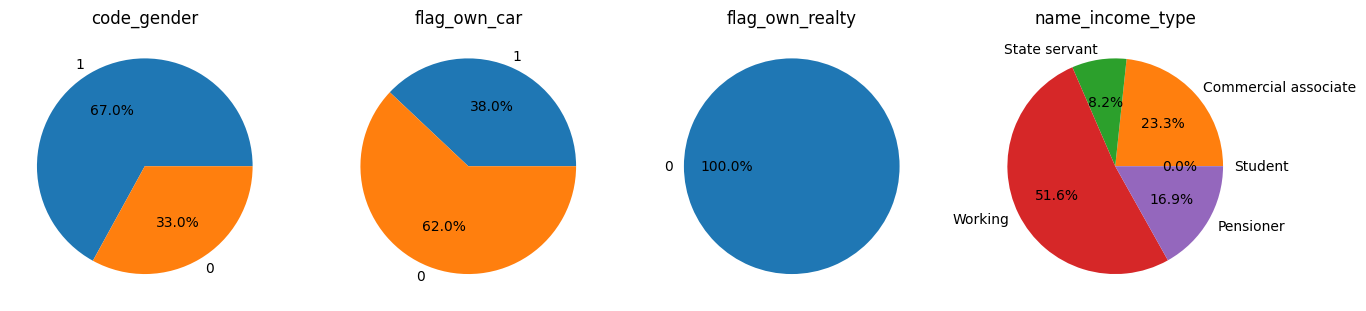

In [25]:
import matplotlib.pyplot as plt
# Checking for distribution of [gender , own_car,  own_property , income_type]
# Define the list of columns names
columns = ['code_gender', 'flag_own_car', 'flag_own_realty', 'name_income_type']
plt.figure(figsize=(16 , 9))
for i in range(len(columns)):
    plt.subplot(1, 4, i+1)
    plt.title(columns[i])  # Use the column name as the title
    
    # Plot pie chart
    counts_df = df_joined_processed.groupBy(columns[i]).count().toPandas()
    
    # Plot pie chart
    plt.pie(counts_df['count'], labels=counts_df[columns[i]], autopct='%1.1f%%')

plt.show()

In [26]:
# checking the count of result
df_joined_processed.groupBy('result').count().orderBy(F.desc('count')).show()

# Observation
# 

+------+-----+
|result|count|
+------+-----+
|  good|16002|
|   bad|11912|
|normal| 8543|
+------+-----+



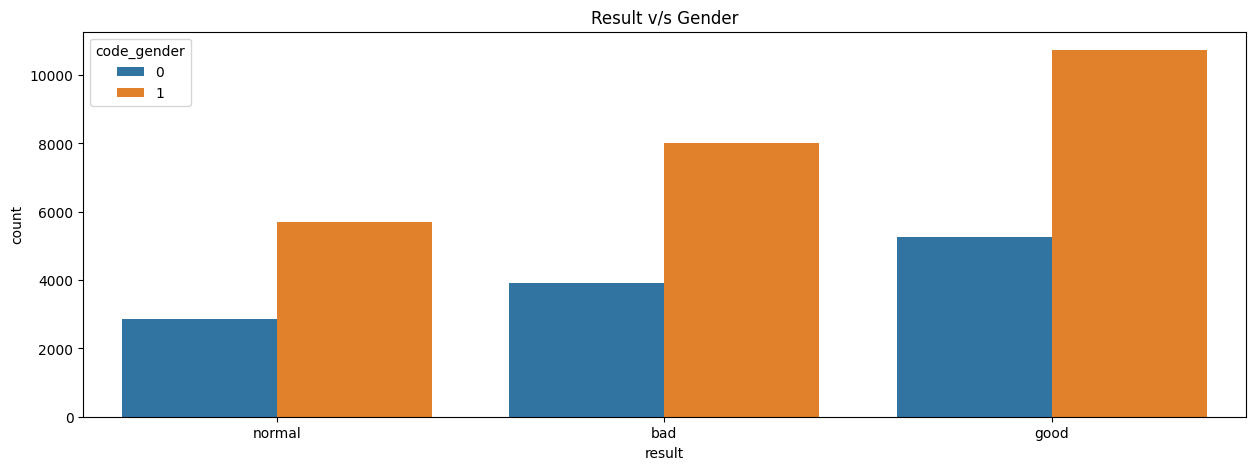

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Menggunakan metode select untuk memilih kolom yang diperlukan
df_plot = df_joined_processed.select('result', 'code_gender')

# Membuat plot
plt.figure(figsize=(15, 5))
sns.countplot(data=df_plot.toPandas(), x='result', hue='code_gender')
plt.title('Result v/s Gender')
plt.xticks(rotation=0)
plt.show()


In [28]:
from pyspark.sql import functions as F

# Perhitungan value count of 'loan status' versus 'gender'
filtered_result = df_joined_processed.groupBy('result', 'code_gender').count()

# Memfilter nilai-nilai yang kurang dari 10000
filtered_result = filtered_result.filter(filtered_result['count'] < 10000)

# Mengubah struktur DataFrame untuk menampilkan dalam format yang diinginkan
filtered_result = filtered_result.groupBy('result').pivot('code_gender').agg(F.first('count'))

# Menampilkan hasil
filtered_result.show()


+------+----+----+
|result|   0|   1|
+------+----+----+
|normal|2852|5691|
|   bad|3909|8003|
|  good|5266|NULL|
+------+----+----+



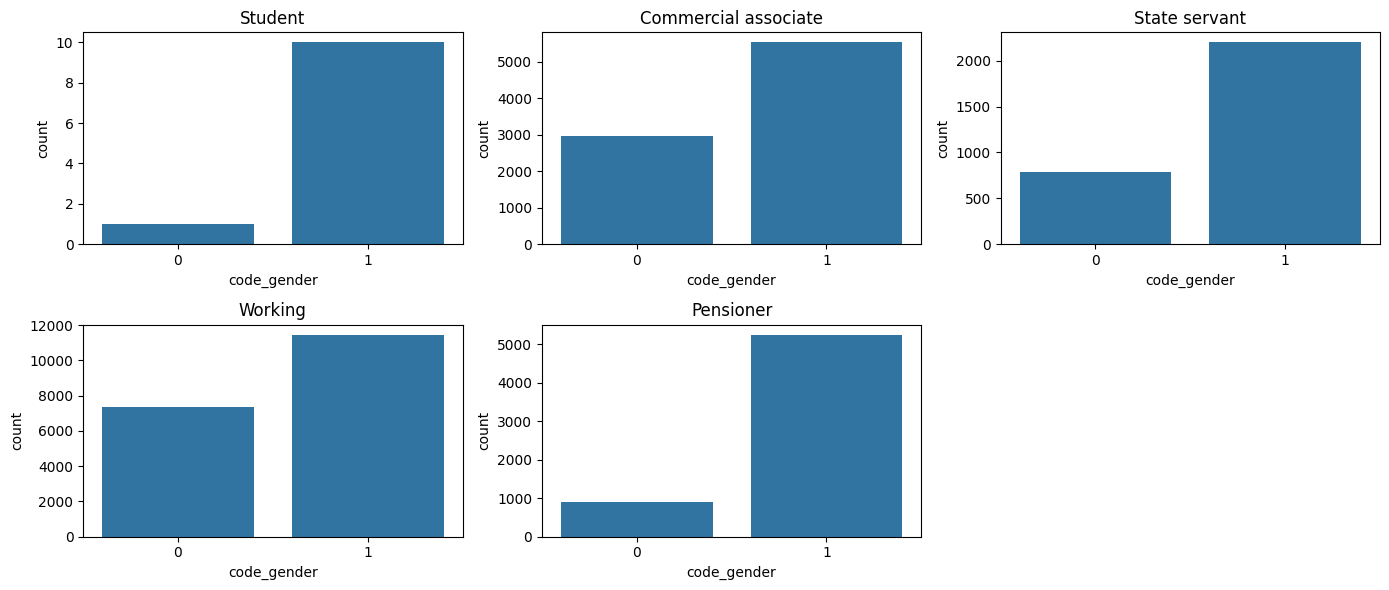

In [29]:
# Relationship between income type and gender
count = df_joined_processed.groupBy('name_income_type').count().toPandas()
plt.figure(figsize=(14, 6))

# Plotting the countplot for each unique value of 'income_type'
for i, income_type in enumerate(count['name_income_type'].unique(), start=1):
    plt.subplot(2, 3, i)
    plt.title(income_type)  # Use the unique value of 'income_type' as the title
    
    # Filter DataFrame based on 'income_type'
    filtered_df = df_joined_processed.filter(df_joined_processed['name_income_type'] == income_type).toPandas()
    
    # Plot countplot
    sns.countplot(data=filtered_df, x='code_gender')

plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

In [30]:
# Relationship between income type and amt_income
df_joined_processed.select('name_income_type', 'amt_income_total').show()

+--------------------+----------------+
|    name_income_type|amt_income_total|
+--------------------+----------------+
|             Working|        427500.0|
|             Working|        427500.0|
|             Working|        112500.0|
|Commercial associate|        270000.0|
|Commercial associate|        270000.0|
|Commercial associate|        270000.0|
|Commercial associate|        270000.0|
|           Pensioner|        283500.0|
|           Pensioner|        283500.0|
|           Pensioner|        283500.0|
|             Working|        270000.0|
|             Working|        270000.0|
|Commercial associate|        135000.0|
|Commercial associate|        135000.0|
|Commercial associate|        135000.0|
|Commercial associate|        135000.0|
|Commercial associate|        135000.0|
|Commercial associate|        135000.0|
|             Working|        130500.0|
|             Working|        130500.0|
+--------------------+----------------+
only showing top 20 rows



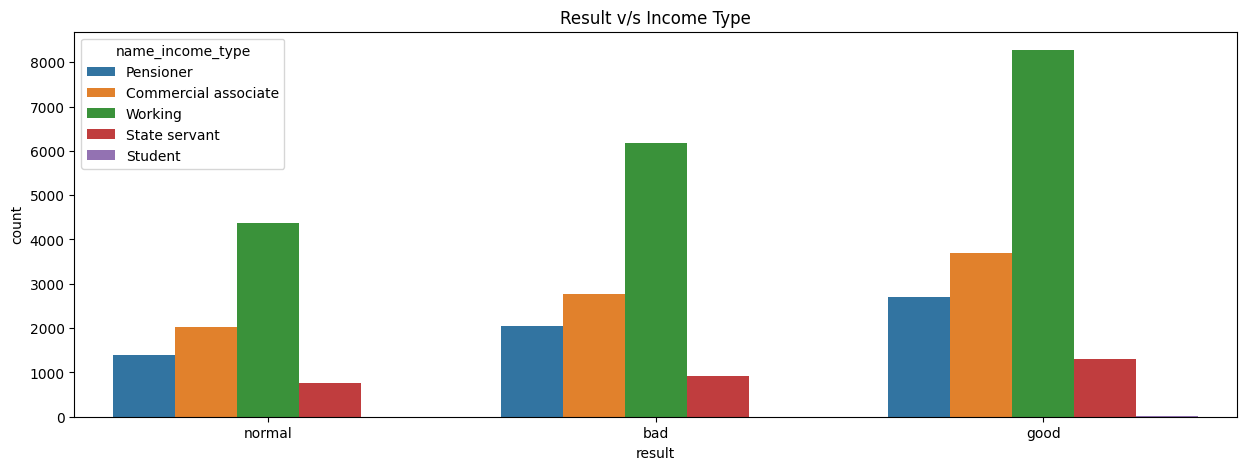

In [31]:
# Relationship between income type and result

df_plot = df_joined_processed.select('result', 'name_income_type')

plt.figure(figsize=(15, 5))
sns.countplot(data=df_plot.toPandas(), x='result', hue='name_income_type')
plt.title('Result v/s Income Type')
plt.xticks(rotation=0)
plt.show()

In [32]:
from pyspark.sql import functions as F

count = df_joined_processed.groupBy('code_gender', 'name_income_type', 'result').count()

filtered_count = count.filter(count['count'] < 1000)

selected_columns = ['code_gender', 'name_income_type', 'result', 'count']
filtered_count = filtered_count.select(selected_columns)

filtered_count.show()


+-----------+--------------------+------+-----+
|code_gender|    name_income_type|result|count|
+-----------+--------------------+------+-----+
|          1|       State servant|normal|  579|
|          1|       State servant|  good|  943|
|          0|       State servant|normal|  186|
|          1|       State servant|   bad|  677|
|          0|Commercial associate|normal|  702|
|          0|       State servant|   bad|  235|
|          0|       State servant|  good|  365|
|          0|           Pensioner|normal|  239|
|          1|             Student|   bad|    1|
|          1|             Student|  good|    8|
|          0|           Pensioner|  good|  377|
|          0|           Pensioner|   bad|  292|
|          0|             Student|normal|    1|
|          1|             Student|normal|    1|
+-----------+--------------------+------+-----+



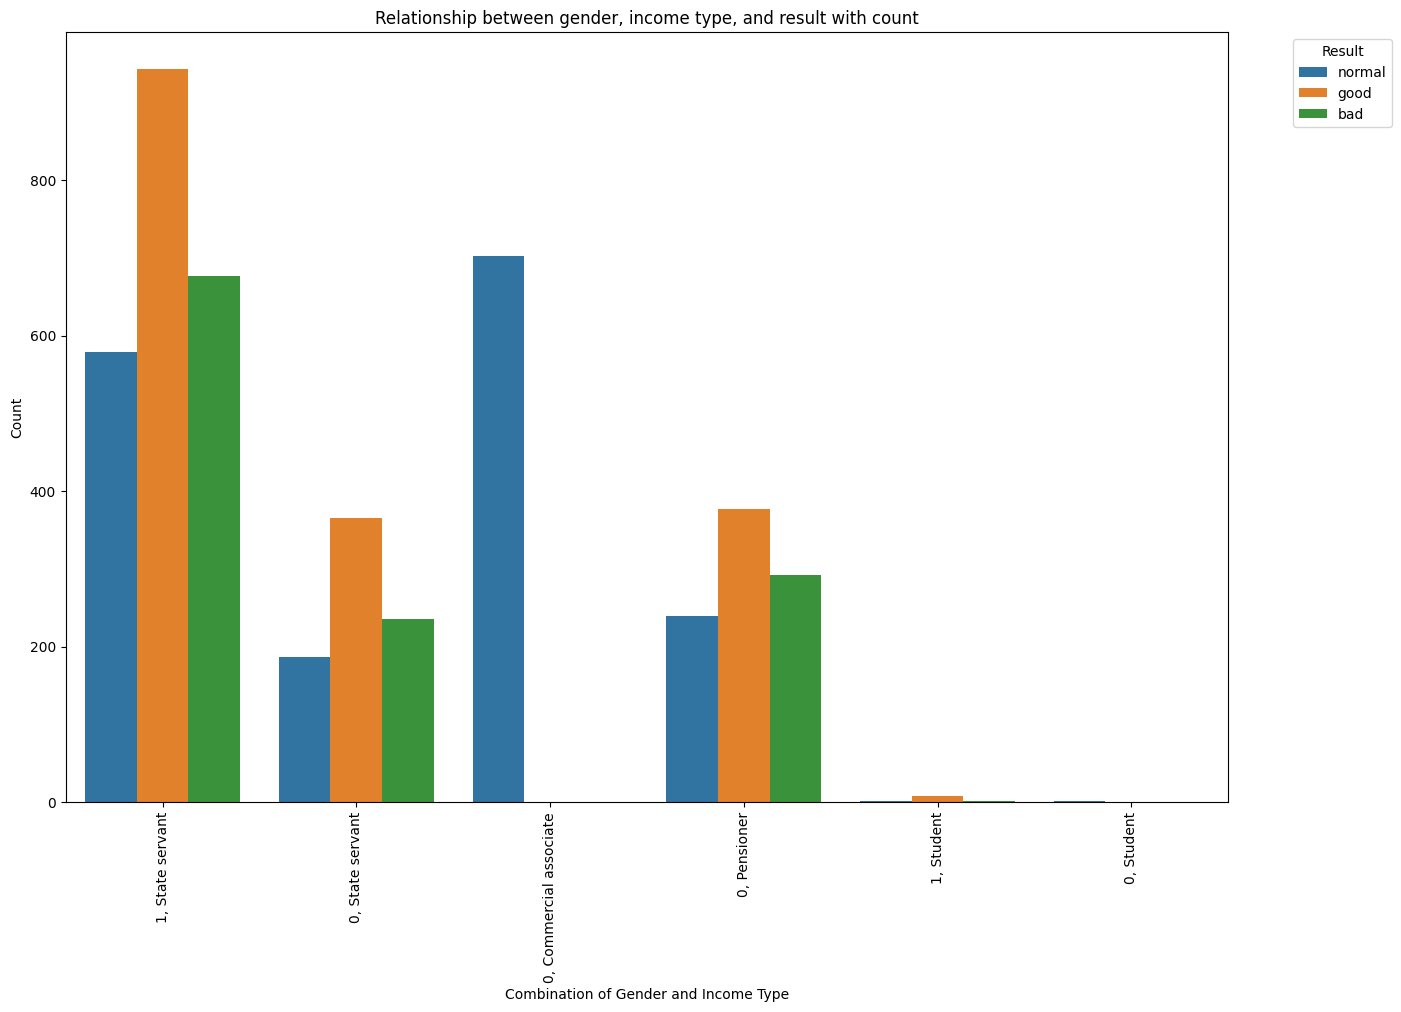

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = filtered_count.toPandas()

data['combined_labels'] = data['code_gender'].astype(str) + ', ' + data['name_income_type']

df_plot = pd.DataFrame({'Labels': data['combined_labels'], 'Result': data['result'], 'Count': data['count']})

plt.figure(figsize=(15, 10))
sns.barplot(data=df_plot, x='Labels', y='Count', hue='Result', dodge=True)
plt.xticks(rotation=90)
plt.xlabel('Combination of Gender and Income Type')
plt.ylabel('Count')
plt.title('Relationship between gender, income type, and result with count')
plt.legend(title='Result', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [34]:
# Education and Gender

# checking the relationship between gender and education
df_joined_processed.groupBy('code_gender','name_education_type').count().orderBy(F.desc('count')).show()


+-----------+--------------------+-----+
|code_gender| name_education_type|count|
+-----------+--------------------+-----+
|          1|Secondary / secon...|16585|
|          0|Secondary / secon...| 8192|
|          1|    Higher education| 6697|
|          0|    Higher education| 3167|
|          1|   Incomplete higher|  880|
|          0|   Incomplete higher|  530|
|          1|     Lower secondary|  244|
|          0|     Lower secondary|  130|
|          1|     Academic degree|   24|
|          0|     Academic degree|    8|
+-----------+--------------------+-----+



<Figure size 1500x500 with 0 Axes>

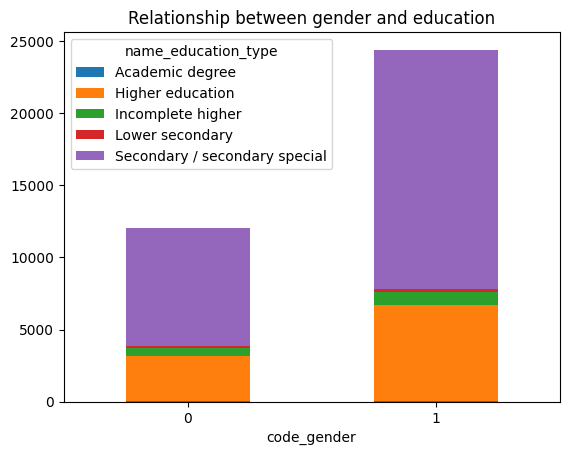

In [35]:
count = df_joined_processed.groupBy(['code_gender', 'name_education_type']).count()

count_pd = count.toPandas()

plt.figure(figsize=(15, 5))
count_pd.pivot(index='code_gender', columns='name_education_type', values='count').plot(kind='bar', stacked=True)

plt.xticks(rotation=0)

plt.title('Relationship between gender and education')
plt.show()


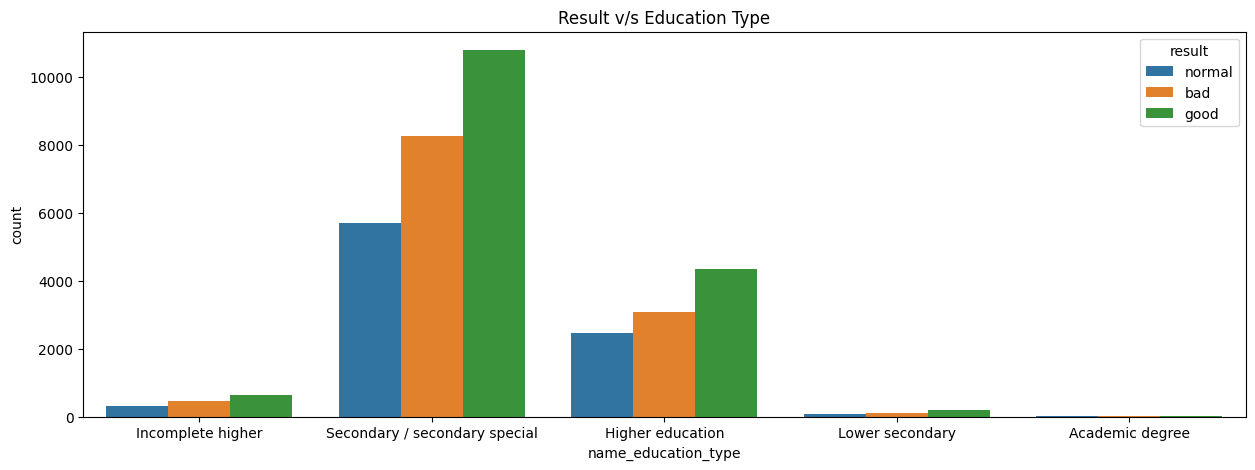

In [36]:
# Relationship Education vs Result

df_plot = df_joined_processed.select('result', 'name_education_type')

plt.figure(figsize=(15, 5))
sns.countplot(data=df_plot.toPandas(), x='name_education_type', hue='result')
plt.title('Result v/s Education Type')
plt.xticks(rotation=0)
plt.show()

In [37]:
# Relationship Housing Type vs Result
# Menggunakan distinct pada kolom housing_type dari DataFrame Spark
unique_housing_types = df_joined_processed.select('name_housing_type').distinct().rdd.flatMap(lambda x: x).collect()
unique_housing_types


['House / apartment',
 'Municipal apartment',
 'Co-op apartment',
 'Rented apartment',
 'Office apartment',
 'With parents']

In [38]:
# checking value counts of `housing_type` column
df_joined_processed.groupBy('name_housing_type').count().orderBy(F.desc('count')).show()

+-------------------+-----+
|  name_housing_type|count|
+-------------------+-----+
|  House / apartment|32548|
|       With parents| 1776|
|Municipal apartment| 1128|
|   Rented apartment|  575|
|   Office apartment|  262|
|    Co-op apartment|  168|
+-------------------+-----+



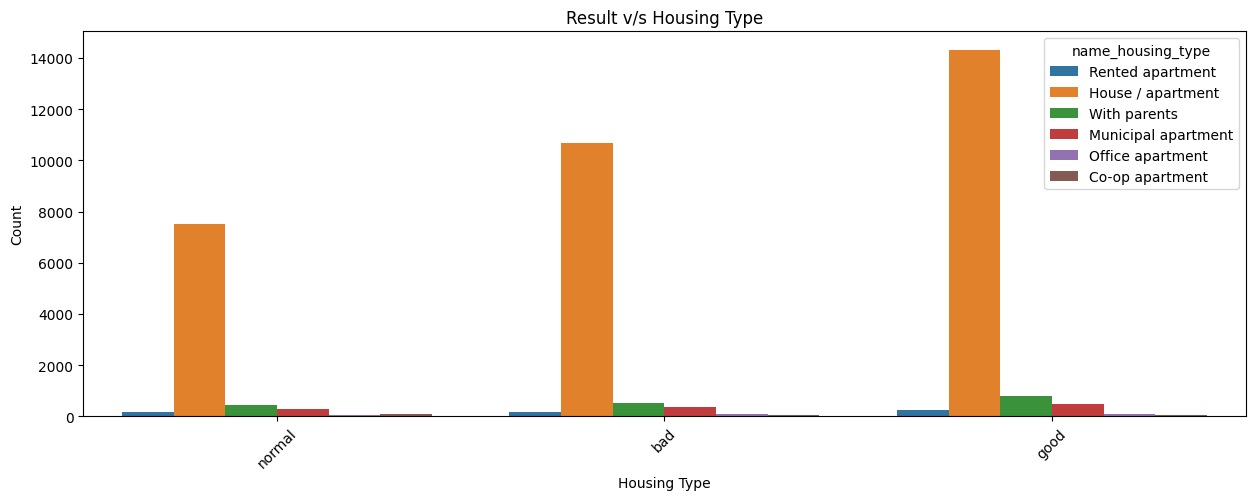

In [39]:
import seaborn as sns

df_plot = df_joined_processed.select('result', 'name_housing_type')

plt.figure(figsize=(15, 5))
sns.countplot(data=df_plot.toPandas(), x='result', hue='name_housing_type')
plt.title('Result v/s Housing Type')
plt.xlabel('Housing Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [40]:
# checking the relationship between loan_status and housing_type

count = df_joined_processed.select('name_housing_type', 'result').groupBy('name_housing_type', 'result').count()

bad_loan = count.filter(F.col('result') == 'bad')

bad_loan.show()


+-------------------+------+-----+
|  name_housing_type|result|count|
+-------------------+------+-----+
|   Rented apartment|   bad|  178|
|       With parents|   bad|  540|
|  House / apartment|   bad|10696|
|   Office apartment|   bad|   94|
|    Co-op apartment|   bad|   38|
|Municipal apartment|   bad|  366|
+-------------------+------+-----+



In [41]:
# Relaationship Family_members and Result
df_joined_processed.groupBy('cnt_fam_members').count().orderBy(F.desc('count')).show()

+---------------+-----+
|cnt_fam_members|count|
+---------------+-----+
|              2|19463|
|              1| 6987|
|              3| 6421|
|              4| 3106|
|              5|  397|
|              6|   58|
|              7|   19|
|             15|    3|
|              9|    2|
|             20|    1|
+---------------+-----+



In [42]:
df_joined_processed.groupBy('cnt_fam_members','result').count().orderBy(F.desc('count')).show()

+---------------+------+-----+
|cnt_fam_members|result|count|
+---------------+------+-----+
|              2|  good| 8663|
|              2|   bad| 6257|
|              2|normal| 4543|
|              1|  good| 3012|
|              3|  good| 2726|
|              1|   bad| 2364|
|              3|   bad| 2141|
|              1|normal| 1611|
|              3|normal| 1554|
|              4|  good| 1390|
|              4|   bad| 1000|
|              4|normal|  716|
|              5|  good|  179|
|              5|   bad|  128|
|              5|normal|   90|
|              6|  good|   24|
|              6|normal|   18|
|              6|   bad|   16|
|              7|normal|   10|
|              7|  good|    6|
+---------------+------+-----+
only showing top 20 rows



In [43]:
# Relationship between children count and result
df_joined_processed.groupBy('cnt_children').count().orderBy(F.desc('count')).show()

+------------+-----+
|cnt_children|count|
+------------+-----+
|           0|25201|
|           1| 7492|
|           2| 3256|
|           3|  419|
|           4|   63|
|           5|   20|
|          14|    3|
|           7|    2|
|          19|    1|
+------------+-----+



In [44]:
df_joined_processed.groupBy('cnt_children','result').count().orderBy(F.desc('count')).show()

+------------+------+-----+
|cnt_children|result|count|
+------------+------+-----+
|           0|  good|11112|
|           0|   bad| 8252|
|           0|normal| 5837|
|           1|  good| 3211|
|           1|   bad| 2460|
|           1|normal| 1821|
|           2|  good| 1463|
|           2|   bad| 1034|
|           2|normal|  759|
|           3|  good|  183|
|           3|   bad|  141|
|           3|normal|   95|
|           4|  good|   24|
|           4|normal|   20|
|           4|   bad|   19|
|           5|normal|   10|
|           5|  good|    7|
|           5|   bad|    3|
|          14|   bad|    2|
|           7|  good|    2|
+------------+------+-----+
only showing top 20 rows



In [45]:
df_joined_processed.groupBy('employed','result').count().show()

+--------+------+-----+
|employed|result|count|
+--------+------+-----+
|       2|normal|  778|
|      17|  good|  135|
|       2|  good| 1321|
|      32|   bad|   12|
|      27|normal|   19|
|      36|normal|    4|
|      40|   bad|    6|
|      17|   bad|   83|
|      18|  good|  112|
|      40|normal|    2|
|       5|   bad|  973|
|       1|   bad|  857|
|      36|  good|   21|
|      33|normal|   15|
|      13|normal|  174|
|       3|   bad|  975|
|      28|  good|   55|
|      16|   bad|  184|
|      26|   bad|   44|
|      44|   bad|    1|
+--------+------+-----+
only showing top 20 rows



In [46]:
filtered_df = df_joined_processed.filter(df_joined_processed['employed'] == 0)

employment_years_count = filtered_df.groupBy('employed').count()

total_count = employment_years_count.select(F.sum('count')).collect()[0][0]

total_count


6135

In [47]:
# Relationship between unemployed and result
filtered_df = df_joined_processed.select('*').filter(df_joined_processed['employed'] == 0)

employment_years_count = filtered_df.groupBy('result').count()

# Tampilkan hasil
employment_years_count.show()

+------+-----+
|result|count|
+------+-----+
|normal| 1385|
|   bad| 2047|
|  good| 2703|
+------+-----+



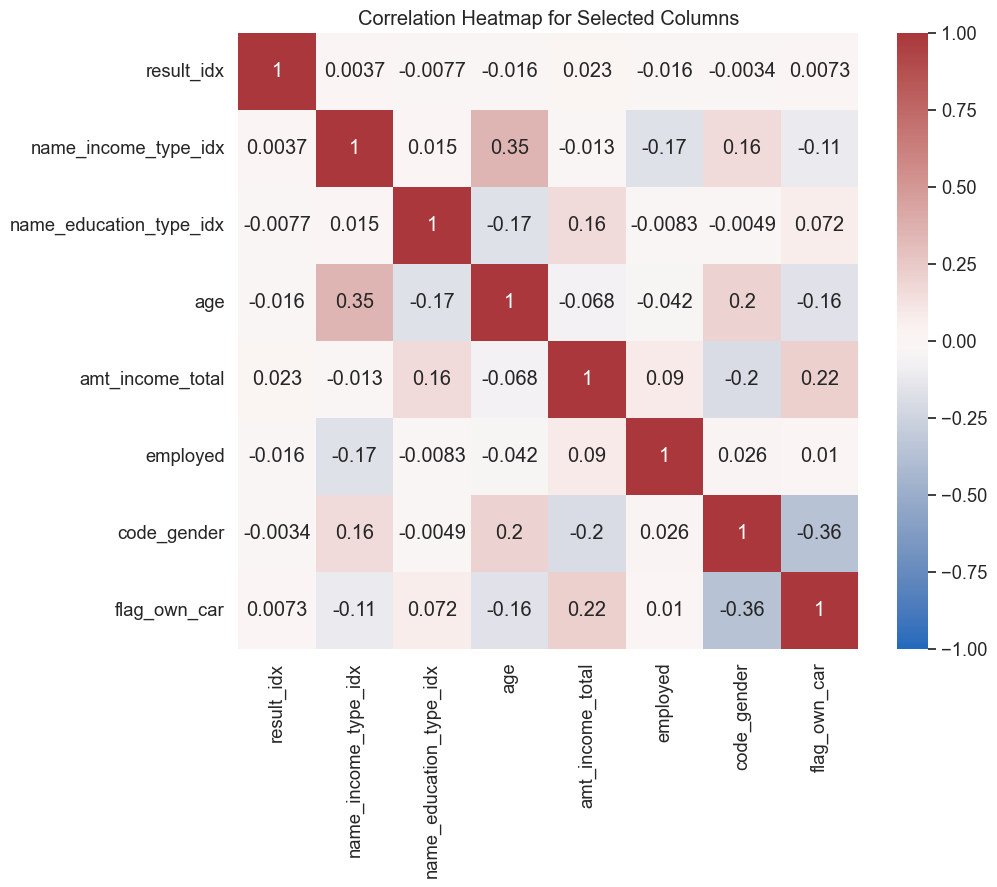

In [48]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dipisah mana yang numerik mana yang bukan
columns_to_index = ['result', 'name_income_type', 'name_education_type']
numeric_columns = ['age', 'amt_income_total', 'employed', 'code_gender', 'flag_own_car']

indexers = [StringIndexer(inputCol=column, outputCol=column + "_idx").fit(df_joined_processed) for column in columns_to_index]

for indexer in indexers:
    df_joined_processed = indexer.transform(df_joined_processed)

# Menggabungkan
selected_columns_with_idx = [col + "_idx" for col in columns_to_index] + numeric_columns

df_selected = df_joined_processed.select(selected_columns_with_idx)

assembler = VectorAssembler(inputCols=selected_columns_with_idx, outputCol="features")
df_vector = assembler.transform(df_selected).select("features")

correlation_matrix = Correlation.corr(df_vector, "features").head()[0]

correlation_matrix_np = correlation_matrix.toArray()
correlation_df = pd.DataFrame(correlation_matrix_np, index=selected_columns_with_idx, columns=selected_columns_with_idx)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
heat = sns.heatmap(data=correlation_df, annot=True, cmap='vlag', vmin=-1, vmax=1)
plt.title('Correlation Heatmap for Selected Columns')
plt.show()

**Extract Feature**
**--**
**Processing with Model**

In [49]:
total_count = count_df.count()
status_class_proportion = status_class_counts.withColumn('proportion', col('count') / lit(total_count))
status_class_proportion.show()

NameError: name 'count_df' is not defined

In [ ]:
columns = data_join.columns
# Membuat DataFrame dari daftar kolom
information = spark.createDataFrame([(col,) for col in columns], ["variable"])

# Menambahkan kolom 'IV' dengan nilai None
information = information.withColumn('IV', lit(None).cast(StringType()))

# Daftar kolom yang akan dihapus
namelist = ['FLAG_MOBIL', 'begin_month', 'dep_value', 'target', 'ID']

# Menghapus kolom-kolom yang ada dalam namelist dari information
for name in namelist:
    information = information.filter(information['variable'] != name)

# Tampilkan hasil
information.show()

In [ ]:
def calc_information_value(df: DataFrame, feature: str, target: str, pr: bool = False):
    # Mengisi nilai NULL
    df = df.withColumn(feature, when(col(feature).isNull(), "NULL").otherwise(col(feature)))
    
    # Menghitung jumlah total, good, dan bad untuk setiap nilai feature
    data = df.groupBy(feature).agg(
        count("*").alias("All"),
        count(when(col(target) == 0, 1)).alias("Good"),
        count(when(col(target) == 1, 1)).alias("Bad")
    )
    
    # Menghitung Share, Bad Rate, Distribution Good, dan Distribution Bad
    total_count = df.count()
    total_bad = df.filter(col(target) == 1).count()
    total_good = total_count - total_bad
    
    data = data.withColumn("Share", col("All") / total_count)
    data = data.withColumn("Bad Rate", col("Bad") / col("All"))
    data = data.withColumn("Distribution Good", (col("All") - col("Bad")) / total_good)
    data = data.withColumn("Distribution Bad", col("Bad") / total_bad)
    
    # Menghitung WoE
    data = data.withColumn("WoE", log(col("Distribution Good") / col("Distribution Bad")))
    
    # Mengganti nilai inf dan -inf dengan 0
    data = data.withColumn("WoE", when(col("WoE") == float("inf"), 0).otherwise(col("WoE")))
    data = data.withColumn("WoE", when(col("WoE") == float("-inf"), 0).otherwise(col("WoE")))
    
    # Menghitung information_value
    data = data.withColumn("information_value", col("WoE") * (col("Distribution Good") - col("Distribution Bad")))
    
    # Mengurutkan data berdasarkan feature dan value
    data = data.orderBy(feature)
    
    # Menghitung total information_value
    information_value = data.agg(sum("information_value")).collect()[0][0]
    
    if pr:
        data.show()
        print('information_value = ', information_value)
    
    print(f"This variable's information_value is: {information_value}")
    data.groupBy(feature).count().show()
    
    return information_value, data

In [ ]:
def convert_dummy(df: DataFrame, feature: str, rank: int = 0) -> DataFrame:
    # Menghitung jumlah kemunculan setiap nilai pada feature
    mode = df.groupBy(feature).count().orderBy(col('count').desc()).collect()[rank][0]
    
    # Membuat dummy variables menggunakan pivot
    dummies = df.groupBy("ID").pivot(feature).agg(lit(1)).na.fill(0)
    
    # Mengganti nama kolom dummy
    for col_name in dummies.columns:
        if col_name != "ID":
            new_name = f"{feature}_{col_name}"
            dummies = dummies.withColumnRenamed(col_name, new_name)
    
    # Menghapus kolom yang paling sering muncul
    dummies = dummies.drop(f"{feature}_{mode}")
    
    # Menghapus kolom asli dari DataFrame
    df = df.drop(feature)
    
    # Menggabungkan kembali dummies dengan DataFrame asli
    df = df.join(dummies, on="ID", how="left")
    
    return df

In [ ]:
def get_category(df, col, binsnum, labels, qcut=False):
    # Menyalin DataFrame asli
    localdf = df.select(col).toPandas()

    if qcut:
        # Quantile cut
        localdf['bins'] = pd.qcut(localdf[col], q=binsnum, labels=labels)
    else:
        # Equal-length cut
        localdf['bins'] = pd.cut(localdf[col], bins=binsnum, labels=labels)
    
    # Membuat DataFrame dari hasil binning
    bins_df = spark.createDataFrame(localdf[['bins']])
    
    # Menggabungkan hasil binning ke DataFrame asli
    name = f'gp_{col}'
    bins_df = bins_df.withColumnRenamed('bins', name)
    df = df.withColumn(name, bins_df[name].cast('string'))
    
    return df


In [ ]:
# Mengganti nilai kolom CODE_GENDER
data_join = data_join.withColumn('CODE_GENDER', when(col('CODE_GENDER') == 'F', 0).when(col('CODE_GENDER') == 'M', 1))
# print(data_join['CODE_GENDER'].value_counts())
# Menghitung value_counts
gender_counts = data_join.groupBy('CODE_GENDER').count()
gender_counts.show()
# Menghitung information value
iv, data = calc_information_value(data_join, 'CODE_GENDER', 'target')
information = information.withColumn('IV', when(col('variable') == 'CODE_GENDER', lit(iv).cast(StringType())).otherwise(col('IV')))
data.show()